First we import some standard libraries and load the oj sales dataset into memory as a dataframe. Our first task is going to be to convert this dataframe into an EstimationDataSet object. In order to do that we need to create a schema that explains the relevant columns. This is accomplished with a schema object as shown below. Notice that it conveys the following information:

* Which columns are "panel_cols". Each unique instance of panel_columns will result in a separate unit within the panel.
* Which column indicates time
* A DataType (NUMERIC vs CATEGORICAL) for each column
* Which columns is the OUTCOME
* Which columns are TREATMENTs for which we may which to infer causal effects

In [35]:
#NB: We manually File->Download as->Python to oj_demand_model.py for running in non-notebook environment
#import sys
#import os
#sys.path.append(os.path.expanduser('~/Source/Repos/PricingEngine/lib/'))

import datetime
import os
import pandas as pd
import numpy as np
from pricingengine import *
data_loc = os.path.dirname(os.getcwd()) + '/data/'
df = pd.read_csv(data_loc + '/oj_retail_data.csv',
                 parse_dates=['week'])

schema = Schema([ColDef('store id', DataType.CATEGORICAL),
                 ColDef('brand', DataType.CATEGORICAL),
                 ColDef('week', DataType.DATE_TIME),
                 ColDef('log sales', DataType.NUMERIC,
                        ColType.OUTCOME),
                 ColDef('featured', DataType.NUMERIC,
                        ColType.TREATMENT),
                 ColDef('log price', DataType.NUMERIC,
                        ColType.TREATMENT),
                 ColDef('AGE60', DataType.NUMERIC),
                 ColDef('EDUC', DataType.NUMERIC),
                 ColDef('ETHNIC', DataType.NUMERIC),
                 ColDef('INCOME', DataType.NUMERIC),
                 ColDef('HHLARGE', DataType.NUMERIC),
                 ColDef('WORKWOM', DataType.NUMERIC),
                 ColDef('HVAL150', DataType.NUMERIC),
                 ColDef('SSTRDIST', DataType.NUMERIC),
                 ColDef('SSTRVOL', DataType.NUMERIC),
                 ColDef('CPDIST5', DataType.NUMERIC),
                 ColDef('CPWVOL5', DataType.NUMERIC)],
                time_colname='week',
                panel_colnames=['store id', 'brand'])


Now before continuing, we need to ensure that our panel is "evenly spaced". I.E. that each pair of consecutive observations has the same spacing between them in the time-dimension. THis is to ensure that the user has properly handled any missing data. The basic idea is to create a "new row" in the dataframe for each missing observation and then to poppulate that row in a sensible way. The default is to go back in time and fill each column with the last non-missing value. However, this is not always appropriate. Sometimes we may wish to poppulate particular columns with a 0 or a nan value for the missing observations. In this case, we may be comfortable saying that a missing observation certainly wasn't "featured" (placed in a prominent position in the store) so we set missing values of that value to zero. However, we may not be comfortable assuming the last available value for sales or price so we may chose to set those to nan.

Now, having appropriately specified a schema and ensured an appropriately spaced panel, we may create an EstimationDataSet object which will be needed for modeling.

In [36]:
df = PdDataframeEx.fill_missing(df,
                                panel_cols=['brand', 'store id'],
                                date_col='week',
                                fill_zero=['featured'],
                                fill_nan=['log price', 'log sales'],
                                day_interval=7)
dataset = EstimationDataSet(df, schema)

Replacing 987 records takes: 0.994117729858317


Now we specifying a Dynamic DML model that will perform both baseline forecasting for our OUTCOME variable and will model the causal impacts of our two TREATMENTs. For convenience, we do this inside the function "train_model" defined below. Note that we have specified the following key options:

* a baseline_model that will be used to get first-stage forecasts of our TREATMENTs and OUTCOMEs
* feature_builders that decribe the regressors on which the baseline models will be trained
* treatment_builders that describe how residuals from our TREATMENT columns are used to shape our second stage regressors
* causal_model which specified the model used to estimate the causal impacts of the second stage regressors
* options which specified the range of leads (in this case 1-3) at which our model is trained. Each lead corresponds to a different temporal gap between the predictive features used as first stage features and the OUTCOME we wish to model. Intuitively, this should map closely to the idea of forecasting at different leads.

In [37]:
def train_model(dataset, tol=.0001, max_iter=1000): #tol & max_iter defaults for LassoCV
    model = DynamicDML(
        dataset.schema,
        baseline_model=LassoCV(tol=tol, max_iter=max_iter),
        causal_model=OLS(),
        options=DDMLOptions(min_lead=1, max_lead=3),
        feature_builders=default_dynamic_featurizer.
        get_featurizer(dataset.schema,
                       min_lag=0,
                       max_lag=4,
                       exclude_dummies=['store id']),
        treatment_builders=[OwnVar('featured'),
                            OwnVar('log price',
                                   interaction_levels=[['brand'],
                                                       ['HVAL150']]),
                            OwnVar('log price', lag=1),
                            PToPVar('log price',
                                    'brand',
                                    {'dominicks' : ['minute.maid',
                                                    'tropicana'],
                                     'tropicana' : ['dominicks',
                                                    'minute.maid'],
                                     'minute.maid' : ['tropicana',
                                                      'dominicks']})])

    model.fit(dataset)
    return model

#Lower tol a bit to deal with convergence warning
model = train_model(dataset, tol=.01, max_iter=16000) 

beta = model.get_coefficients()
se = model.get_standard_errors()
t = pd.DataFrame({'t':beta['coef'] / se['se']})

tab=pd.concat([beta, se, t], axis=1)
tab

coef  \
Feature Type                         auxiliary_interaction             
Own_featured_outcomelag_0_difflag_0                         0.845928   
Own_log price_outcomelag_0_difflag_0                       -3.208695   
                                     HVAL150                0.895377   
                                     brand.minute.maid     -0.389236   
                                     brand.tropicana        0.317859   
Own_log price_outcomelag_1_difflag_0                        0.492293   
Peer_brand_outcomelag_0              minute.maid#dominicks  0.484142   
                                     tropicana#dominicks   -0.087979   
                                     tropicana#minute.maid -0.092338   
                                     dominicks#minute.maid  1.056747   
                                     dominicks#tropicana    0.278224   
                                     minute.maid#tropicana  0.298946   

                                                                  se  \
Feature Type                         auxiliary_interaction             
Own_featured_outcomelag_0_difflag_0                         0.007185   
Own_log price_outcomelag_0_difflag_0                        0.036323   
                                     HVAL150                0.059573   
                                     brand.minute.maid      0.034419   
                                     brand.tropicana        0.031717   
Own_log price_outcomelag_1_difflag_0                        0.019165   
Peer_brand_outcomelag_0              minute.maid#dominicks  0.016886   
                                     tropicana#dominicks    0.013976   
                                     tropicana#minute.maid  0.017233   
                                     dominicks#minute.maid  0.030530   
                                     dominicks#tropicana    0.026425   
                                     minute.maid#tropicana  0.017996   

                                                                     t  
Feature Type                         auxiliary_interaction              
Own_featured_outcomelag_0_difflag_0                         117.728793  
Own_log price_outcomelag_0_difflag_0                        -88.338282  
                                     HVAL150                 15.029846  
                                     brand.minute.maid      -11.308695  
                                     brand.tropicana         10.021684  
Own_log price_outcomelag_1_difflag_0                         25.687301  
Peer_brand_outcomelag_0              minute.maid#dominicks   28.670794  
                                     tropicana#dominicks     -6.295098  
                                     tropicana#minute.maid   -5.358307  
                                     dominicks#minute.maid   34.613700  
                                     dominicks#tropicana     10.528988  
                                     minute.maid#tropicana   16.612030

Above you can see a table of regression coefficients corresponding to all of the treatments created by our treatment_builders. In order these describe, the impact of being features on log sales, the impact of contemporaneous log price on log sales (i.e. a demand elasticity), the impact of lagged price on sales (i.e. a "pull foward" of demand), and various cross-price effects (i.e. cannibalization). To better organize the impacts of these coefficients, we can organize them with a "marginal effects" object. This is shown immeidately below, the table should be read as to give the impact of the log price of the (brand, lead) combination in each row onto the log sales of (brand, lead) combination of each column. The marginal effects object is especially useful for demand applications (like this one) because it can be interpreted as a cross-elasticity matrix.

In [38]:
mfx = model.get_marginal_effects(
    'log price',
    'brand',
    filter_dic={'store id' : ['100']})
mfx.mfx

brand            dominicks                     minute.maid            \
store id               100                             100             
lead                     1         2         3           1         2   
lead brand                                                             
1    dominicks   -3.198740  0.492293  0.000000    0.484142  0.000000   
     minute.maid  1.056747  0.000000  0.000000   -3.587976  0.492293   
     tropicana    0.278224  0.000000  0.000000    0.298946  0.000000   
2    dominicks    0.000000 -3.198740  0.492293    0.000000  0.484142   
     minute.maid  0.000000  1.056747  0.000000    0.000000 -3.587976   
     tropicana    0.000000  0.278224  0.000000    0.000000  0.298946   
3    dominicks    0.000000  0.000000 -3.198740    0.000000  0.000000   
     minute.maid  0.000000  0.000000  1.056747    0.000000  0.000000   
     tropicana    0.000000  0.000000  0.278224    0.000000  0.000000   

brand                      tropicana                      
store id                         100                      
lead                     3         1         2         3  
lead brand                                                
1    dominicks    0.000000 -0.087979  0.000000  0.000000  
     minute.maid  0.000000 -0.092338  0.000000  0.000000  
     tropicana    0.000000 -2.880881  0.492293  0.000000  
2    dominicks    0.000000  0.000000 -0.087979  0.000000  
     minute.maid  0.492293  0.000000 -0.092338  0.000000  
     tropicana    0.000000  0.000000 -2.880881  0.492293  
3    dominicks    0.484142  0.000000  0.000000 -0.087979  
     minute.maid -3.587976  0.000000  0.000000 -0.092338  
     tropicana    0.298946  0.000000  0.000000 -2.880881

We can also see standard errors for our marginal effects matrix using:

In [39]:
mfx.mfx_se

brand            dominicks                     minute.maid            \
store id               100                             100             
lead                     1         2         3           1         2   
lead brand                                                             
1    dominicks    0.035923  0.019165  0.000000    0.016886  0.000000   
     minute.maid  0.030530  0.000000  0.000000    0.033145  0.019165   
     tropicana    0.026425  0.000000  0.000000    0.017996  0.000000   
2    dominicks    0.000000  0.035923  0.019165    0.000000  0.016886   
     minute.maid  0.000000  0.030530  0.000000    0.000000  0.033145   
     tropicana    0.000000  0.026425  0.000000    0.000000  0.017996   
3    dominicks    0.000000  0.000000  0.035923    0.000000  0.000000   
     minute.maid  0.000000  0.000000  0.030530    0.000000  0.000000   
     tropicana    0.000000  0.000000  0.026425    0.000000  0.000000   

brand                      tropicana                      
store id                         100                      
lead                     3         1         2         3  
lead brand                                                
1    dominicks    0.000000  0.013976  0.000000  0.000000  
     minute.maid  0.000000  0.017233  0.000000  0.000000  
     tropicana    0.000000  0.029281  0.019165  0.000000  
2    dominicks    0.000000  0.000000  0.013976  0.000000  
     minute.maid  0.019165  0.000000  0.017233  0.000000  
     tropicana    0.000000  0.000000  0.029281  0.019165  
3    dominicks    0.016886  0.000000  0.000000  0.013976  
     minute.maid  0.033145  0.000000  0.000000  0.017233  
     tropicana    0.017996  0.000000  0.000000  0.029281

Finally, we may also wish to assess the overall ability of our model to predict sales. Below we split our dataset into a training and test sample with the goal to minimize out of sample sMAPE on sales in stores 101 and 100. We train two separate models on our training data: one includes training data from all stores, one restricts attention to just stores '101' and '100'. We then compare out of sample performance. We see that the model trained just on the data from stores '101' and '100' did slightly better in out of sample prediction.

In [40]:
training_data = dataset.filter(
    last_date=datetime.datetime(2002, 1, 1))
training_data_sub = dataset.filter(
    last_date=datetime.datetime(2002, 1, 1),
    filter_dic={'store id' : ['101', '100']})
testing_data = dataset.filter(
    first_date=datetime.datetime(2002, 1, 8),
    filter_dic={'store id' : ['101', '100']})

#get smapes from large model
model_all = train_model(training_data)
pred_all = Predictions(model_all, testing_data,
                             outcome_is_log=True)
print(pred_all.get_smape(names=['store id']))

#Get smapes from small model
model_sub = train_model(training_data_sub)
pred_sub = Predictions(model_sub, testing_data,
                             outcome_is_log=True)
print(pred_sub.get_smape(names=['store id']))

lead                   1             2             3
error_view percent_error percent_error percent_error
store id                                            
100            44.012762     45.769813     46.652580
101            40.656224     41.010010     41.909185
lead                   1             2             3
error_view percent_error percent_error percent_error
store id                                            
100            42.226265     43.575022     44.163177
101            40.003123     39.477350     38.373831


Finally, we illustrate the use of our model for task of price-aware forecasting (e.g. promotion evaluation). Suppose we wish to consider whether or not we want to run a two-week promotion on Tropicana orange juice in store 100 where we set the price to a fixed value of \$2.50 (as compared to a baseline of \$3) in each week. First let us create datasets that correspond to each of those two scenarios and then use the model to forecast sales.

In [41]:
baseline_scenario = dataset.filter(
    first_date=datetime.datetime(2001, 9, 1),
    last_date=datetime.datetime(2002, 3, 1),
    filter_dic={'store id' : ['100']})


baseline_scenario = baseline_scenario.append_data_one_instance(
    panel_dic={'store id' : '100', 'brand' : 'tropicana'},
    treatments_path={'log price' : [np.log(3) for x in range(2)]},
    start_date=datetime.datetime(2002, 1, 12))

promo_scenario = baseline_scenario.append_data_one_instance(
    panel_dic={'store id' : '100', 'brand' : 'tropicana'},
    treatments_path={'log price' : [np.log(2.5) for x in range(2)]},
    start_date=datetime.datetime(2002, 1, 12))


base_pred = Predictions(model, baseline_scenario, outcome_is_log=True)
promo_pred = Predictions(model, promo_scenario, outcome_is_log=True)

This creates a Predictions object for each scenario. The .data value Predictions object lists forecasted sales for each observation and lead (of prediction) along with a forecasted margin of error (as well as actual sales) if they are available. However, for the narrow comparison we have in mind, we wish to organize this object to get the foreward looking forecasts from the vantge point of the week before our promotion (1/5/2002) and then make an intuitive plot that shows the impacts. Note that you will need to pip install the matplotlib package in order to run the code below.

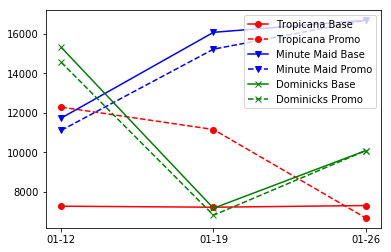

In [42]:
import matplotlib.pyplot as plt

base_df = base_pred.get_projections_from_date(
    datetime.datetime(2002, 1, 5), coverage=.9).reset_index()
promo_df = promo_pred.get_projections_from_date(
    datetime.datetime(2002, 1, 5), coverage=.9).reset_index()


plt.close()
use = base_df['brand'] == 'tropicana'
plt.plot(base_df.loc[use, 'week'],
         base_df.loc[use, 'prediction'],
         'ro-',
         label='Tropicana Base')
use = promo_df['brand'] == 'tropicana'
plt.plot(promo_df.loc[use, 'week'],
         promo_df.loc[use, 'prediction'],
         'ro--',
         label='Tropicana Promo')
use = base_df['brand'] == 'minute.maid'
plt.plot(base_df.loc[use, 'week'],
         base_df.loc[use, 'prediction'],
         'bv-',
         label='Minute Maid Base')

use = promo_df['brand'] == 'minute.maid'
plt.plot(promo_df.loc[use, 'week'],
         promo_df.loc[use, 'prediction'],
         'bv--',
         label='Minute Maid Promo')

use = base_df['brand'] == 'dominicks'
plt.plot(base_df.loc[use, 'week'],
         base_df.loc[use, 'prediction'],
         'gx-',
         label='Dominicks Base')

use = promo_df['brand'] == 'dominicks'
plt.plot(promo_df.loc[use, 'week'],
         promo_df.loc[use, 'prediction'],
         'gx--',
         label='Dominicks Promo')
x = promo_df.loc[use, 'week'].values
x_f = x.astype('float')
#X data type conversions from datetime differ depending on exact pkg config
if x_f[0]<=plt.gca().get_xticks()[-1]:
    x = x_f
plt.xticks(x, promo_df.loc[use, 'week'].dt.strftime('%m-%d').values)
plt.legend(loc=1)
plt.show()

In the plot above, the dashed lines show the forecasted impact in the promo (price of tropicana=\$2.5) case as comapred to solid lines showing the \$3 baseline. As you can see, the first two weeks reflect increased sales for Tropicana (some of which comes at the expense of it's competitors), while the final week the promotion is over and we see a small "pull-forward" effect where Tropicana is expected to have slightly fewer sales as a result of the promotion.